# Librerías

In [180]:
import pandas as pd
import numpy as np

# Para hacer resumen del df
from summarytools import dfSummary

# Estadísticas
from statistics import median
from scipy.stats import zscore
from pyod.models.mad import MAD
from scipy.stats import median_abs_deviation
from scipy.spatial import distance # Para distancia de Mahalanobis

# scikit-learn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# 1. A partir del dataset ruidoso.txt realice los siguientes análisis:

## a. Cargue y explore el dataset explicando en qué consiste y las características que posee el mismo.

In [181]:
ruidoso = pd.read_csv("data/ruidoso.txt")

Se usa la función **read_csv** de pandas para leer la información contenida en el archivo ruidoso.txt, y se guarda esta en un objeto llamado **ruidoso**.

In [182]:
dfSummary(ruidoso, is_collapsible=False)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Unnamed: 0[int64],Mean (sd) : 33.5 (19.2)min < med < max:1.0 < 33.5 < 66.0IQR (CV) : 32.5 (1.7),66 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACR0lEQVR4nO3Zu47aUBhF4f9wk7nIFkKBjmbKSClc8hB52DxCCp6AIk0qOiSEjPCMhTFOk6Qc8HEcz5bXV3PYFlozCNuVZWnAR9dr+wKAZwwevcA5Nzazkef7X8uyfPM828ntmrttb/fM7O559t3rfjdU59x4sVh8DcNw7rN8Pp9PzrlvPh9cF7fr7ra5XRTFME3Tl9ls9rPX6+VVzz+67kf/UUdhGM43m81bFEVZleEkSYLtdjs/Ho8jM/P5C+/itvdu29v7/X6+2+0+xXH8Y7Vanaqcfea6H371m5lFUZQtl8vXKuO/jT3OdH67xm5r26fTaWxmNp1OG/nM+DEFCYQKCYQKCYQKCYQKCYQKCU/dnvJVFMXQzELnnM/x8H6/Dzu2XWu37e0mNRZqmqbDPM+/rNfrfr/fr3wDOc/zoCiKz1mWfTezSvflVLfr7La93bTGQr1er4MgCCZxHGdVn1SY/X3SMbndbv2ubNfZbXu7aY1+9Zv5P6n486SjS9v/Yrft7abwYwoSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSBs+8KEmSoOobXy6XwMwsTdPgcDhM/ud51W3V6657/pm+fgFCZ6mynxud/gAAAABJRU5ErkJggg=="">",0(0.0%)
2,Road_55dB[int64],Mean (sd) : 159228.8 (484751.3)min < med < max:7600.0 < 37550.0 < 3108200.0IQR (CV) : 59950.0 (0.3),61 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB40lEQVR4nO3XsU7CUBSH8XNEsUTpDUUZeQBMfAB2HX1YV3dWBl+CpZFWY4kNuW4uJmIvGvzH7zf33HuTfm1TjzEa8NcdHfoAwHcc77rA3Qdm1k9c/y3G2CTOAh++DNXdB+Px+C7P81HK4nVdP7n7PbFiX7veqP08z0fz+bwJIWy6LFxVVbZYLEZlWfbNjFCxl52ffjOzEMJmMpm8Jqw/SJgBPuFnChIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRKOD32Ar7j7wMz6ieNvMcbmJ8+Dw/nVULfb7YmZ5e6eMp4VRXEbQjhLGa7r+snd7/9brId8uH9z72+FWlVV1nXX1Wo1bNv2ejqd9nq93qbrfNu2mZldzWazx+Fw+Nxltmma0+VyeVmW5YW71133FpYVRXETQjhPGV6v1y/u/mBmne/XvnvverG8A+3sY8cpONmSAAAAAElFTkSuQmCC"">",0(0.0%)
3,Road_60dB[int64],Mean (sd) : 78587.9 (251409.0)min < med < max:4000.0 < 17400.0 < 1469100.0IQR (CV) : 24425.0 (0.3),63 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB80lEQVR4nO3XQW7aQBiG4f8vqYNVmJFxw5IDUIkDcIAuc9gcgi0SvQSbUWRXqmlc5O66aQXxpGn6Se+z5huP5FcgfBgGA/537976AsBz3Fz7gLuXZlZknv80DEOXuQV+uRiqu5d1Xd+HEKqcw9u2fXT3B2LFS137Ri1CCNV2u+1ijKcxBzdNM93tdlVKqTAzQsWLXP3pNzOLMZ6Wy+W3jPPLjA3wG/5MQQKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQsLNW1/gEncvzazInD8Nw9D9zfvgstd8X68a6vl8fm9mwd1z5tPFYvE5xvghZ9y27aO7PxDrv+HuZV3X9yGEKmd/7X09K9SmaaZjH3w8Hud9329Wq9VkMpmcxu77vp+a2af1ev1lPp9/HbPtuu52v9/fpZQ+uns79tnIEmaz2d1ms/lRluX3McOu624Ph0OVUirM7I+h/gS4/GS7jFUA0wAAAABJRU5ErkJggg=="">",0(0.0%)
4,Railways_65dB[int64],Mean (sd) : 1139.4 (4778.8)min < med < max:0.0 < 100.0 < 29700.0IQR (CV) : 400.0 (0.2),18 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABpUlEQVR4nO3XQWrbUBSG0feMa2wwErbBG+guPM+0i80ivIsuwQQJXIcEVZ11ElLHMjT54ZypdK/e4ENCdRzHAl/d7LMPAB8xv3ZDrXVVSllM3P8yjuNl4iz89c9Qa62r3W73o2mazZTlfd8/1Vofxcq9rr1RF03TbA6Hw6Vt2+dbFnddtzwej5vT6bQopQiVu1z99JdSStu2z/v9/teE/asJM/CGnykiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiS

A continuación se crea una función de usuario para verificar si una lista de valores son todos consecutivos y distintos entre sí.

In [183]:
def son_diferentes_consecutivos(lista):
    for i in range(len(lista) - 1):
        if lista[i] == lista[i + 1]:
            return False
        if lista[i] + 1 != lista[i + 1]:
            return False
    return True

# Verificar si los valores son diferentes y consecutivos
variable = "Unnamed: 0"
if son_diferentes_consecutivos(ruidoso[variable]):
    print(f"Los valores de la variable {variable} son diferentes y consecutivos.")
else:
    print(f"Los valores de la variable {variable} no son diferentes y consecutivos.")

Los valores de la variable Unnamed: 0 son diferentes y consecutivos.


Las variables en este archivo parecen representar diferentes tipos de ruido (presumiblemente en diferentes áreas o ubicaciones), y los valores numéricos parecen ser mediciones de niveles de ruido en decibelios (dB) en diferentes condiciones ambientales.

Una descripción tentativa de las variables podría ser:

- Road_55dB: Esta variable parece representar mediciones de ruido provenientes de carreteras con un nivel de 55 decibelios (dB).

- Road_60dB: Esta variable parece representar mediciones de ruido provenientes de carreteras con un nivel de 60 decibelios (dB).

- Railways_65dB: Esta variable parece representar mediciones de ruido provenientes de ferrocarriles con un nivel de 65 decibelios (dB).

- Industry_65dB: Esta variable parece representar mediciones de ruido provenientes de industrias con un nivel de 65 decibelios (dB).

Con la ayuda de la función **dfSummary**, se obtiene un resumen del dataframe **ruidoso**. se puede observar que este dataframe tiene una dimensión de 66 filas y 5 columnas, no tiene duplicados y las 5 variables son numéricas, sin embargo, la primera variable **Unnamed: 0** contiene 66 valores distintos que va desde 1 hasta 66 (verificado con la función de usuario), por lo que en realidad esta variable es un índice del dataframe y no una variable como tal. Por último, se puede observar que la variable **Industry_65dB** tiene un valor faltante, y dicho valor faltante está afectando la salida de los estadísticos de resumen tales como la media y la mediana de esta variable, por lo tanto, se usará otra función para conocer los estadísticos de resumen de esta.

In [184]:
ruidoso.set_index('Unnamed: 0', drop=True, inplace=True)
ruidoso.index.name = None 
ruidoso

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
1,166400,79200,1100,0.0
2,20000,11000,0,0.0
3,37800,18000,0,0.0
4,24500,16700,0,100.0
5,103100,33500,1900,200.0
...,...,...,...,...
62,20700,16200,0,0.0
63,15100,9900,0,0.0
64,24500,12400,300,300.0
65,12800,8500,0,0.0


Del anterior código, la variable **Unnamed: 0** se transformó en índece.

In [185]:
ruidoso.describe()

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
count,6.600000e+01,6.600000e+01,66.000000,65.000000
mean,1.592288e+05,7.858788e+04,1139.393939,180.000000
std,4.847513e+05,2.514090e+05,4778.827625,537.993959
min,7.600000e+03,4.000000e+03,0.000000,0.000000
25%,1.895000e+04,1.007500e+04,0.000000,0.000000
50%,3.755000e+04,1.740000e+04,100.000000,0.000000
75%,7.890000e+04,3.450000e+04,400.000000,100.000000
max,3.108200e+06,1.469100e+06,29700.000000,4000.000000


Usando la función **describe** se obtiene los estadísticos de resumen para la variable **Industry_65dB** que no se pudo obtener usando la función **dfSummary** debido el valor faltante. De esta forma, se puede observar que la media de estas 4 variables numéricas es mayor a la mediana, por lo que se espera que la distribución de cada una de estas variables sea sesgada hacia la derecha como visto en los histogramas de la función **dfSummary**. También, se puede observar que la variabilidad presente en cada una de estas variables es relativamente alta. Por lo último, también se tiene el mínimo, los percentiles, y el máximo de cada una de las variables.

## b. Realice un breve análisis exploratorio para identificar la distribución de las variables usadas en la base de datos ¿será que existe relación entre las variables?

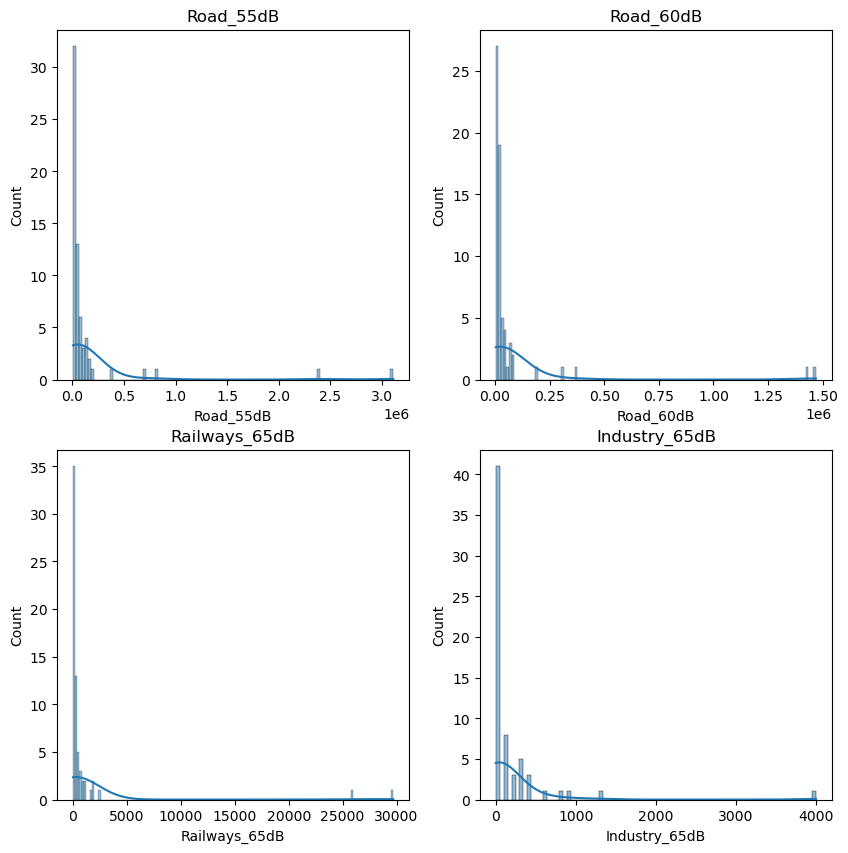

In [186]:
# Crear una figura y ejes utilizando subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Crear gráficos de distribución para cada variable en la cuadrícula de ejes
sns.histplot(ruidoso['Road_55dB'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Road_55dB')

sns.histplot(ruidoso['Road_60dB'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Road_60dB')

sns.histplot(ruidoso['Railways_65dB'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Railways_65dB')

sns.histplot(ruidoso['Industry_65dB'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Industry_65dB')

plt.show()

De las anteriores gráficas, se puede observar que la distribución de cada una de las variables tienen formas muy parecidas, especialmente entre las variables **Road_55dB** y **Road_60dB**. Por lo tanto, se puede creer que estas variables tengan algún tipo de relación, para esto, se usará gráficas de dispersión y medidas de correlación.

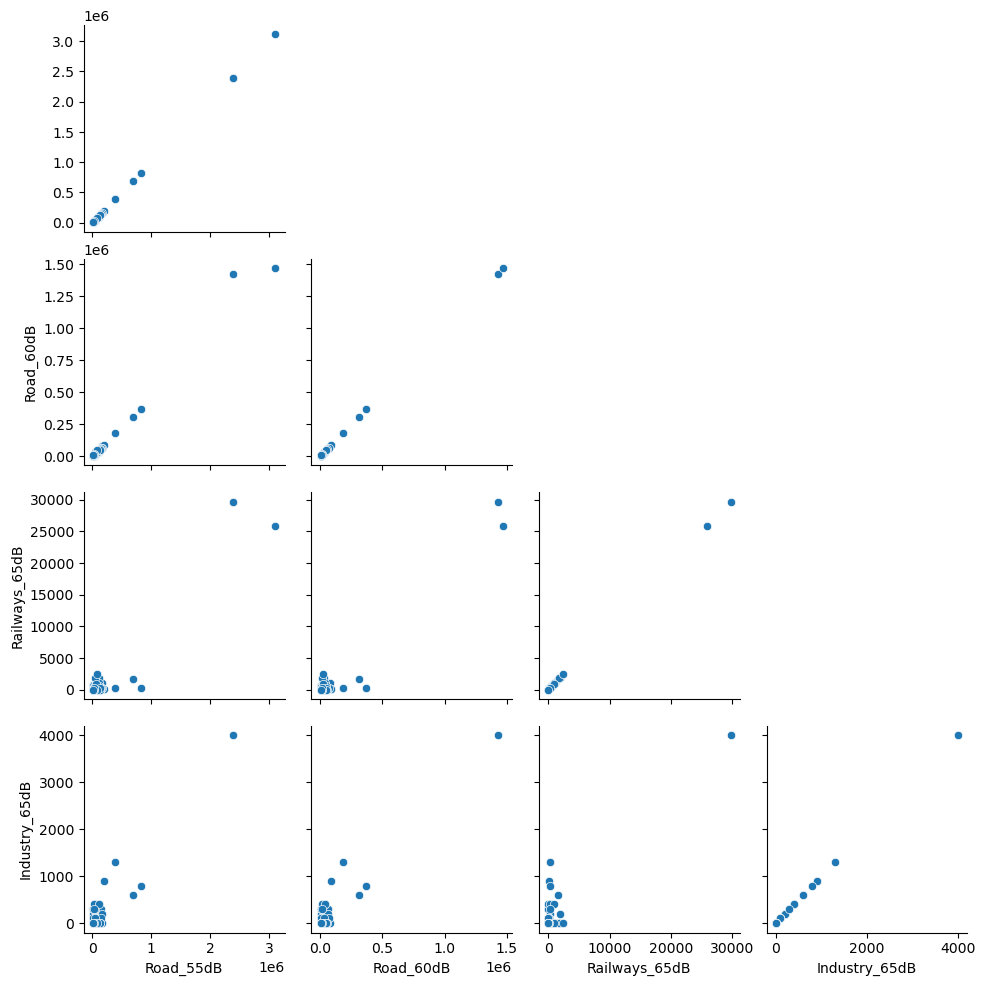

In [187]:
sns.pairplot(ruidoso,
             corner=1,
             diag_kind=None)
plt.show()

Del anterior código se creó gráficos de dispersión por pares con la ayuda de la función **pairplot** de **seaborn**. Aquí, se puede ver claramente que las variables **Road_60dB** y **Road_55dB** tienen una relación lineal, mientras que las otras combinaciones de las variables no tienen una relación lineal. Por último, se puede observar que existen valores atípicos a nivel bivariado.

<AxesSubplot:>

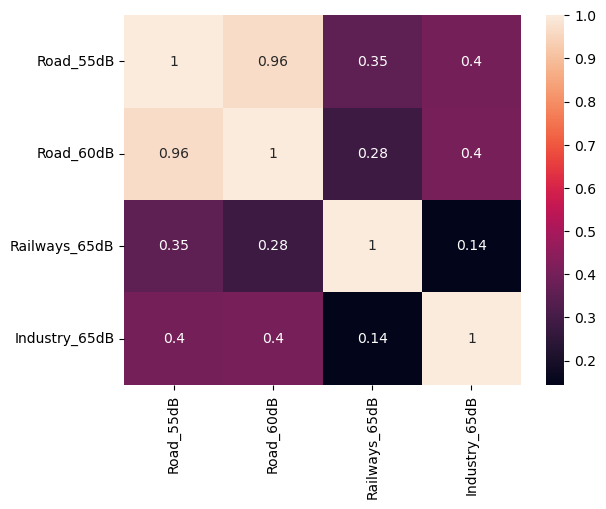

In [188]:
sns.heatmap(ruidoso.corr(method="spearman"), annot=True)

Teniendo en cuenta el anterior análisis, se empleó la medida de correlación de spearman para cuantificar la correlación existente entre las variables. Se puede observar que las variables con más correlación son **Road_60dB** y **Road_55dB** con un valor de 0.96, mientras que la correlación en las otras variables no superan 0.4, es decir, tienen una correlación relativamente débil.

## c. Verifique si existen problemas de datos atípicos en cada una de las variables usando las metodologías de detección a nivel univariado.

### Boxplots

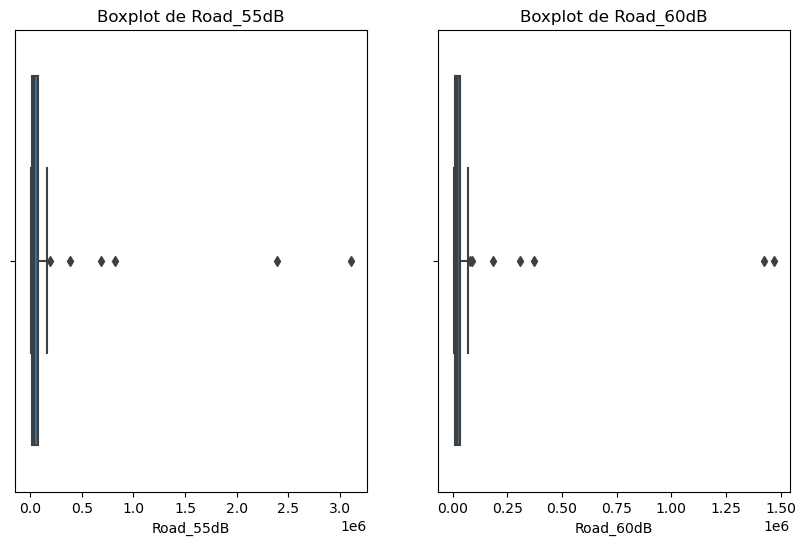

In [189]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,6))

axes[0].set_title("Boxplot de Road_55dB")
axes[1].set_title("Boxplot de Road_60dB")

sns.boxplot(ax=axes[0], data = ruidoso, x = "Road_55dB")
sns.boxplot(ax=axes[1], data = ruidoso, x = "Road_60dB")

plt.show()

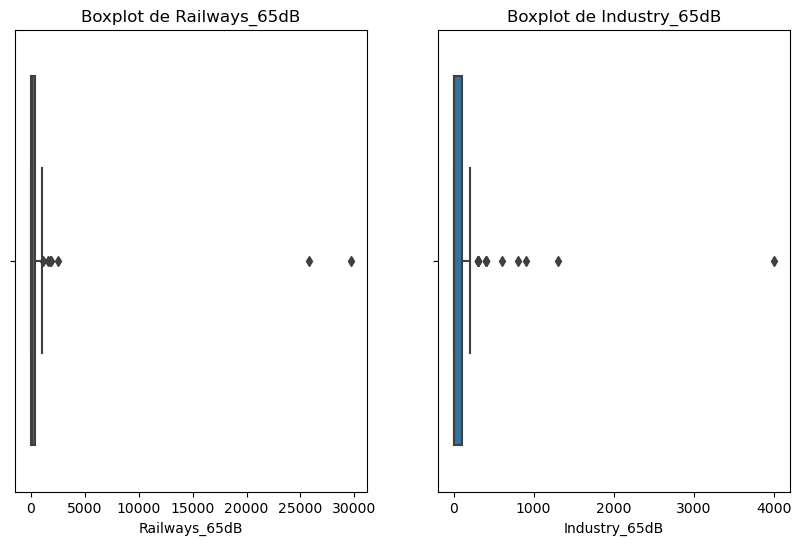

In [190]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,6))

axes[0].set_title("Boxplot de Railways_65dB")
axes[1].set_title("Boxplot de Industry_65dB")

sns.boxplot(ax=axes[0], data = ruidoso, x = "Railways_65dB")
sns.boxplot(ax=axes[1], data = ruidoso, x = "Industry_65dB")

plt.show()

Usando los boxplots se puede observar que existen datos atípicos a nivel univariado en cada una de las variables.

### z-score

In [191]:
# Calculate z-score for each data point and compute its absolute value
z_scores = zscore(ruidoso['Road_55dB'], nan_policy="omit")
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = ruidoso[abs_z_scores > 3]
outliers.Road_55dB

49    2387200
66    3108200
Name: Road_55dB, dtype: int64

In [192]:
# Calculate z-score for each data point and compute its absolute value
z_scores = zscore(ruidoso['Road_60dB'], nan_policy="omit")
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = ruidoso[abs_z_scores > 3]
outliers.Road_60dB

49    1426100
66    1469100
Name: Road_60dB, dtype: int64

In [193]:
# Calculate z-score for each data point and compute its absolute value
z_scores = zscore(ruidoso['Railways_65dB'], nan_policy="omit")
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = ruidoso[abs_z_scores > 3]
outliers.Railways_65dB

49    29700
66    25800
Name: Railways_65dB, dtype: int64

In [194]:
# Calculate z-score for each data point and compute its absolute value
z_scores = zscore(ruidoso['Industry_65dB'], nan_policy="omit")
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = ruidoso[abs_z_scores > 3]
outliers.Industry_65dB

49    4000.0
Name: Industry_65dB, dtype: float64

Empleando el método de zscore con un umbral de 3 a cada una de las variables, se puede observar que según este criterio solo hay 2 valores atípicos (observación 49 y 66) por variable exceptuando la variable **Industry_65dB** que solo tiene un valor atípico (observación 49). Sin embargo, no se puede confiar en los resultados de este criterio, ya que las distribuciones vistas anteriormente no son simétricas y no se distribuyen normal.

### z-score modificado

Este método pretende calcular la siguiente cantidad:

$$
M_i =  \frac{{0.6745*(x_i-Mediana)}}{{MAD}}
$$

Hay que tener en cuenta que la cantidad MAD no puede ser nulo.

In [195]:
# Set threshold to 3.5
mad = MAD(threshold = 3.5)

# Convert the 'total' column into a 2D numpy array
Road_55dB_reshaped = ruidoso['Road_55dB'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(Road_55dB_reshaped).labels_

# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 7


In [196]:
outliers = ruidoso[labels == 1]
outliers.Road_55dB

1      166400
8      388000
13     192900
15     823200
29     689300
49    2387200
66    3108200
Name: Road_55dB, dtype: int64

Usando el método de z-score modificado se ha encontrado 7 valores atípicos para la variable **Road_55dB**. Este criterio es más confiable que el z-score, ya que la distribución de esta variable es asimétrica.

In [197]:
# Convert the 'total' column into a 2D numpy array
Road_60dB_reshaped = ruidoso['Road_60dB'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(Road_60dB_reshaped).labels_

# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 10


In [198]:
outliers = ruidoso[labels == 1]
outliers.Road_60dB

1       79200
8      185200
13      86000
15     371700
18      66200
27      67300
29     309300
45      69700
49    1426100
66    1469100
Name: Road_60dB, dtype: int64

Usando el método de z-score modificado se ha encontrado 10 valores atípicos para la variable **Road_60dB**. Este criterio es más confiable que el z-score, ya que la distribución de esta variable es asimétrica.

In [199]:
# Convert the 'total' column into a 2D numpy array
Railways_65dB_reshaped = ruidoso['Railways_65dB'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(Railways_65dB_reshaped).labels_

# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 11


In [200]:
outliers = ruidoso[labels == 1]
outliers.Railways_65dB

1      1100
5      1900
11      700
29     1600
30      800
32     1000
41     1800
49    29700
50     2500
56      900
66    25800
Name: Railways_65dB, dtype: int64

Usando el método de z-score modificado se ha encontrado 11 valores atípicos para la variable **Railways_65dB**. Este criterio es más confiable que el z-score, ya que la distribución de esta variable es asimétrica.

In [201]:
# Eliminar filas con valores NaN en la columna 'Industry_65dB'
ruidoso_cleaned = ruidoso.dropna(subset=['Industry_65dB'])

# Convertir la columna 'Industry_65dB' a un arreglo numpy 2D
Industry_65dB_cleaned = ruidoso_cleaned['Industry_65dB'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(Industry_65dB_cleaned).labels_

# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 24


c:\Users\David\anaconda3\lib\site-packages\pyod\models\mad.py:129: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(np.ravel(0.6745 * diff / self.median_diff_))
c:\Users\David\anaconda3\lib\site-packages\pyod\models\mad.py:129: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.ravel(0.6745 * diff / self.median_diff_))
c:\Users\David\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [202]:
outliers = ruidoso_cleaned[labels == 1]
outliers.Industry_65dB

4      100.0
5      200.0
6      100.0
7      300.0
8     1300.0
9      200.0
10     100.0
12     100.0
13     900.0
15     800.0
18     300.0
19     300.0
20     300.0
21     400.0
26     400.0
27     200.0
29     600.0
32     400.0
38     100.0
45     100.0
49    4000.0
54     100.0
58     100.0
64     300.0
Name: Industry_65dB, dtype: float64

In [203]:
# Obtain the MAD value
mad_score = median_abs_deviation(ruidoso_cleaned['Industry_65dB']) # Industry_65dB
mad_score

0.0

Usando el método de z-score modificado se ha encontrado 24 valores atípicos para la variable **Industry_65dB**. Este criterio presenta problemas ya que el MAD tiene el valor de 0, por lo tanto no se puede confiar en los resultados de la anterior salida.

### Rango intercuartil (IQR)

Primeramente, se crea una función de usuario **atipico_intercuartil** que permite encontrar los datos atípicos usando el método intercuartil, la función imprime un mensaje de cuántos datos atípicos halló bajo este método y retorna los datos atípicos de la respectiva variable.

In [204]:
def atipico_intercuartil(data, variable):
    '''
    Descripción: función de usuario que permite hallar datos atípicos usando el método de rango intercuartil (IQR).

    data: dataframe de pandas.
    variable: variable a utilizar para hallar los datos atípicos. String
    '''
    # Calculate the percentiles
    seventy_fifth = data[variable].quantile(0.75)
    twenty_fifth = data[variable].quantile(0.25)

    # Obtain IQR
    iqr = seventy_fifth - twenty_fifth

    # Upper and lower thresholds
    upper = seventy_fifth + (1.5 * iqr)
    lower = twenty_fifth - (1.5 * iqr)

    # Subset the dataset
    outliers = data[(data[variable] < lower) | (data[variable] > upper)]
    print(f"Se detectan {len(outliers[variable])} valores atípicos en la variable {variable} usando el método intercuartil")
    return outliers[variable]

In [205]:
atipico_intercuartil(ruidoso, "Road_55dB")

Se detectan 6 valores atípicos en la variable Road_55dB usando el método intercuartil


8      388000
13     192900
15     823200
29     689300
49    2387200
66    3108200
Name: Road_55dB, dtype: int64

In [206]:
atipico_intercuartil(ruidoso, "Road_60dB")

Se detectan 7 valores atípicos en la variable Road_60dB usando el método intercuartil


1       79200
8      185200
13      86000
15     371700
29     309300
49    1426100
66    1469100
Name: Road_60dB, dtype: int64

In [207]:
atipico_intercuartil(ruidoso, "Railways_65dB")

Se detectan 7 valores atípicos en la variable Railways_65dB usando el método intercuartil


1      1100
5      1900
29     1600
41     1800
49    29700
50     2500
66    25800
Name: Railways_65dB, dtype: int64

In [208]:
atipico_intercuartil(ruidoso, "Industry_65dB")

Se detectan 13 valores atípicos en la variable Industry_65dB usando el método intercuartil


7      300.0
8     1300.0
13     900.0
15     800.0
18     300.0
19     300.0
20     300.0
21     400.0
26     400.0
29     600.0
32     400.0
49    4000.0
64     300.0
Name: Industry_65dB, dtype: float64

En conclusión, este método puede ser el más adecuado para la detección de los datos atípicos a nivel univariado para los datos usados en este ejercicio, ya que este método no requiere que los datos se distribuyan como una normal y no presenta problemas numéricos como el método de z-score modificado para la variable **Industry_65db**.

## d. ¿Se detectan valores atípicos a nivel multivariado?

Teniendo en cuenta que existe un valor faltante y esto afecta el cálculo de la distancia de Mahalanobis, se procede a imputar el valor faltante por la mediana de la respectiva variable.

In [209]:
ruidoso_sin_faltante = ruidoso.fillna(median(ruidoso.Industry_65dB))
ruidoso_sin_faltante.tail()

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
62,20700,16200,0,0.0
63,15100,9900,0,0.0
64,24500,12400,300,300.0
65,12800,8500,0,0.0
66,3108200,1469100,25800,0.0


### Distancia de Mahalanobis

In [210]:
# Calculamos la matriz de covarianza de las variables
cov_matrix = np.cov(ruidoso_sin_faltante, rowvar=False)

# Calculamos la inversa de la matriz de covarianza
cov_inv = np.linalg.inv(cov_matrix)

# Calculamos la distancia de Mahalanobis para cada fila en el DataFrame
dist_mahalanobis = []
for row in ruidoso_sin_faltante.values:
    dist = distance.mahalanobis(row, ruidoso_sin_faltante.mean(), cov_inv)
    dist_mahalanobis.append(dist)

# Agregamos la distancia de Mahalanobis como una nueva columna en el DataFrame
ruidoso_sin_faltante['mahalanobis_distance'] = dist_mahalanobis

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance
1,166400,79200,1100,0.0,0.700726
2,20000,11000,0,0.0,0.724467
3,37800,18000,0,0.0,0.700625
4,24500,16700,0,100.0,0.641624
5,103100,33500,1900,200.0,3.196330
...,...,...,...,...,...
62,20700,16200,0,0.0,1.150109
63,15100,9900,0,0.0,0.800643
64,24500,12400,300,300.0,1.109024
65,12800,8500,0,0.0,0.764907


In [225]:
# Ordenamos el DataFrame por la columna de distancia de Mahalanobis en orden descendente
df_sorted = ruidoso_sin_faltante.sort_values(by='mahalanobis_distance', ascending=False)

# Seleccionamos aquellos registros con las distancias mayor a 2
distancia_mayor_a_dos = df_sorted[df_sorted.mahalanobis_distance >= 2]
distancia_mayor_a_dos

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score
49,2387200,1426100,29700,4000.0,7.930110,13.401267
66,3108200,1469100,25800,0.0,7.772388,15.602701
15,823200,371700,300,800.0,5.383971,10.668763
8,388000,185200,300,1300.0,4.321800,7.136681
13,192900,86000,100,900.0,3.368562,1.549033
29,689300,309300,1600,600.0,3.313313,9.165655
50,77200,24300,2500,0.0,3.207822,0.951998
5,103100,33500,1900,200.0,3.196330,1.240279
32,102800,41600,1000,400.0,2.290744,1.180531
41,47500,17400,1800,0.0,2.081142,1.127663


In [239]:
len(distancia_mayor_a_dos)

11

Usando la distancia de Mahalanobis y usando un criterio personal (distancia mayor o igual a 2), se han encontrado 11 valores atípicos a nivel multivariado.

### Local Outlier Factor

Para este método de búsqueda de datos atípicos, se usará los 5 vecinos más cercanos y no la configuración predeterminada.

In [221]:
# Calculamos el LOF para las tres variables
lof = LocalOutlierFactor(n_neighbors = 5)
lof.fit_predict(ruidoso_sin_faltante)

# Obtenemos los scores LOF para cada punto
scores_lof = -lof.negative_outlier_factor_

# Agregamos los scores LOF como una nueva columna en el DataFrame
ruidoso_sin_faltante['lof_score'] = scores_lof

# Mostramos el DataFrame con los scores LOF
ruidoso_sin_faltante

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score
1,166400,79200,1100,0.0,0.700726,1.184494
2,20000,11000,0,0.0,0.724467,1.101867
3,37800,18000,0,0.0,0.700625,0.986031
4,24500,16700,0,100.0,0.641624,0.979519
5,103100,33500,1900,200.0,3.196330,1.240279
...,...,...,...,...,...,...
62,20700,16200,0,0.0,1.150109,1.159004
63,15100,9900,0,0.0,0.800643,0.975804
64,24500,12400,300,300.0,1.109024,0.994866
65,12800,8500,0,0.0,0.764907,1.011528


In [224]:
# Ordenamos el DataFrame por la columna 'lof_score' en orden descendente
df_sorted = ruidoso_sin_faltante.sort_values(by='lof_score', ascending=False)

# Seleccionamos los primeros diez registros con los scores LOF más grandes
primeros_diez_lof = df_sorted.head(10)
primeros_diez_lof

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score
66,3108200,1469100,25800,0.0,7.772388,15.602701
49,2387200,1426100,29700,4000.0,7.930110,13.401267
15,823200,371700,300,800.0,5.383971,10.668763
29,689300,309300,1600,600.0,3.313313,9.165655
8,388000,185200,300,1300.0,4.321800,7.136681
30,7600,4000,800,0.0,0.974601,1.698795
13,192900,86000,100,900.0,3.368562,1.549033
25,17700,5800,0,0.0,0.450939,1.506205
24,8600,5800,100,0.0,0.651516,1.472590
38,31600,10700,200,100.0,0.566397,1.464228


In [228]:
distancia_mayor_a_dos.index

Int64Index([49, 66, 15, 8, 13, 29, 50, 5, 32, 41, 61], dtype='int64')

Del anterior dataframe ordenado de mayor a menor mediante el criterio lof_score, se puede observar que los primeros 5 registros tiene un lof_scores relativamente altos, por lo tanto estas observaciones se pueden considerar como potenciales atípicos a nivel multivariado. Cabe destarcar, que estos 5 registros también se consideran como atípicos usando el método de distancia de Mahalanobis.

### Isolation Forest

In [237]:
# Definimos la cantidad de árboles
n_arboles = 300

# Inicializamos y ajustamos el modelo Isolation Forest con la cantidad de árboles especificada
isolation_forest = IsolationForest(n_estimators=n_arboles, random_state=42)
puntajes_anomalia = isolation_forest.fit(ruidoso_sin_faltante)

# Obtenemos los puntajes de anomalía para cada muestra
puntajes_anomalia = isolation_forest.score_samples(ruidoso_sin_faltante)

# Convertimos los puntajes de anomalía a valores positivos
puntajes_anomalia = -puntajes_anomalia

# Obtenemos las etiquetas de anomalía (inlier/outlier) para cada punto
#etiquetas_anomalia = isolation_forest.predict(df_selected)

# Agregamos las etiquetas de anomalía como una nueva columna en el DataFrame
ruidoso_sin_faltante['puntajes_anomalia'] = puntajes_anomalia

# Ordenamos el DataFrame por los puntajes de anomalía en orden descendente
df_sorted = ruidoso_sin_faltante.sort_values(by='puntajes_anomalia', ascending=False)

# Seleccionamos los primeros diez registros con los puntajes de anomalía más altos
puntaje_mayor_a_un_medio = df_sorted[df_sorted.puntajes_anomalia > 0.5]
puntaje_mayor_a_un_medio

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score,puntajes_anomalia
49,2387200,1426100,29700,4000.0,7.930110,13.401267,0.798670
66,3108200,1469100,25800,0.0,7.772388,15.602701,0.792813
15,823200,371700,300,800.0,5.383971,10.668763,0.684241
8,388000,185200,300,1300.0,4.321800,7.136681,0.675898
29,689300,309300,1600,600.0,3.313313,9.165655,0.665750
13,192900,86000,100,900.0,3.368562,1.549033,0.616185
50,77200,24300,2500,0.0,3.207822,0.951998,0.564258
5,103100,33500,1900,200.0,3.196330,1.240279,0.532627
1,166400,79200,1100,0.0,0.700726,1.184494,0.530318
32,102800,41600,1000,400.0,2.290744,1.180531,0.513076


In [238]:
len(puntaje_mayor_a_un_medio)

12

Usando el método de isolation forest con 300 árboles y un criterio personal (puntajes_anomalia > 0.5), se ha detectado 12 datos atípicos. Cabe destacar que los primeros 5 datos atípicos hallados coinciden con los hallados en los primeros dos métodos de detección de datos atípicos a nivel multivariado. Por lo tanto, se puede concluir que los datos con índices 49, 66, 15, 8 y 29 son potenciales atípicos a nivel multivariado.

## e. Para el caso univariado, escoja una variable y realice un análisis sobre las implicaciones que tiene realizar diferentes tratamientos a los datos atípicos en la distribución de la respectiva variable.

Para este ejercicio se elige la variable **Railways_65dB**.

# zona de prueba

In [114]:
#ruidoso['Industry_65dB'].values.dropna()
Industry_65dB_reshaped = ruidoso['Industry_65dB'].values.reshape(-1, 1)
Industry_65dB_reshaped

array([[   0.],
       [   0.],
       [   0.],
       [ 100.],
       [ 200.],
       [ 100.],
       [ 300.],
       [1300.],
       [ 200.],
       [ 100.],
       [   0.],
       [ 100.],
       [ 900.],
       [   0.],
       [ 800.],
       [   0.],
       [   0.],
       [ 300.],
       [ 300.],
       [ 300.],
       [ 400.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [ 400.],
       [ 200.],
       [   0.],
       [ 600.],
       [   0.],
       [   0.],
       [ 400.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [ 100.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [ 100.],
       [   0.],
       [   0.],
       [   0.],
       [4000.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [ 100.],
       [   0.],
       [   0.],
       [   0.],
       [ 100.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [

In [113]:
# Eliminar filas con valores NaN en la columna 'Industry_65dB'
ruidoso_cleaned = ruidoso.dropna(subset=['Industry_65dB'])

# Convertir la columna 'Industry_65dB' a un arreglo numpy 2D
Industry_65dB_cleaned = ruidoso_cleaned['Industry_65dB'].values.reshape(-1, 1)
Industry_65dB_cleaned

array([[   0.],
       [   0.],
       [   0.],
       [ 100.],
       [ 200.],
       [ 100.],
       [ 300.],
       [1300.],
       [ 200.],
       [ 100.],
       [   0.],
       [ 100.],
       [ 900.],
       [   0.],
       [ 800.],
       [   0.],
       [   0.],
       [ 300.],
       [ 300.],
       [ 300.],
       [ 400.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [ 400.],
       [ 200.],
       [   0.],
       [ 600.],
       [   0.],
       [   0.],
       [ 400.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [ 100.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [ 100.],
       [   0.],
       [   0.],
       [   0.],
       [4000.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [ 100.],
       [   0.],
       [   0.],
       [   0.],
       [ 100.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [

0.01